In [1]:
import numpy as np
import pandas as pd
import pylab as pl
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
#Import
firearms = pd.read_csv('firearms.csv')
shootings = pd.read_csv('mass_shootings.csv')
population = pd.read_csv('world_pop.csv', skiprows=3)
gdp = pd.read_csv('gdp.csv', skiprows=3)

#Refine
population = population[['Country Name', '2012']]
population = population.rename(columns = {'Country Name':'Country', 
                                          '2012':'pop'})

gdp = gdp[['Country Name', '2012']]
gdp = gdp.rename(columns = {'Country Name':'Country', '2012':'gdp'})

firearms = firearms[['Country/Territory','Average total all civilian firearms', 
                     'Number of homicides by firearm', ]]
firearms = firearms.rename(columns = {'Country/Territory':'Country',
                                     'Average total all civilian firearms':'civ_firearms',
                                     'Number of homicides by firearm':'homicides_by_firearm'})

shootings = shootings.rename(columns = {'Guns/100 inhabitants':'guns_per_100_inhabitants',
                                     'Number of mass shootings':'mass_shootings',})

df = firearms.merge(population, left_on='Country', right_on='Country')
df = df.merge(gdp, left_on='Country', right_on='Country')
df_ = df.merge(shootings, left_on='Country', right_on='Country')
df_['country_name'] = df_['Country']
df_ = df_.set_index(['Country'])
df_.head()

,civ_firearms,homicides_by_firearm,pop,gdp,guns_per_100_inhabitants,mass_shootings,country_name
Country,,,,,,,
Australia,3050000.0,30.0,22728254.0,1.538194e+12,15.0,4,Australia
Austria,2500000.0,18.0,8429991.0,4.074516e+11,30.4,1,Austria
Canada,9950000.0,173.0,34750545.0,1.824289e+12,30.8,4,Canada
Denmark,650000.0,15.0,5591572.0,3.271489e+11,12.0,0,Denmark
Finland,2400000.0,24.0,5413971.0,2.567065e+11,45.3,2,Finland


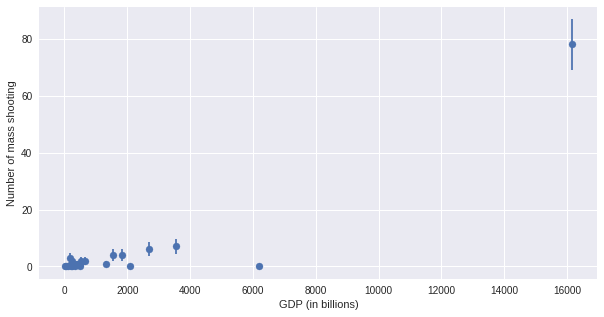

Number of mass shooting vs GDP, errors represent Poisson statistics.
The datapoint to the top right of the plot is the USA, which has noth the highest GDP and the highest number of mass shootings


In [3]:
fig = pl.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)

scatter = ax.scatter(df_.gdp / 1e9, df_['mass_shootings'])
ax.errorbar(df_.gdp / 1e9, df_['mass_shootings'], 
            yerr = np.sqrt(df_['mass_shootings'] * 1.0), fmt = '.')
ax.set_xlabel("GDP (in billions)")
ax.set_ylabel("Number of mass shooting")
ax.set_ylim()
pl.show()
print ("Number of mass shooting vs GDP, " + 
       "errors represent Poisson statistics.\n" + 
       "The datapoint to the top right of the plot is the USA, " + 
       "which has noth the highest GDP and the highest number of mass shootings")

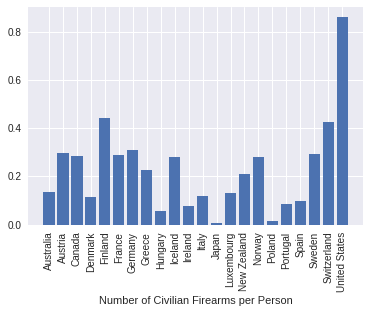

In [14]:
df_['shootingspp'] = df_["mass_shootings"] / df_['pop'] * 1e3
df_['firearms_per_pop'] = df_['civ_firearms'] / df_['pop']

fig, ax = pl.subplots()
x = range(0, len(df_['country_name']))
ax.bar(x, df_['civ_firearms'] / df_['pop'])
plt.xticks(x, df_.country_name, rotation='vertical')
ax.set_xlabel('Number of Civilian Firearms per Person');

**Description**<br>
We see here that the number of firearms per person is nearly twice as high in the United States as anywhere else in the world.

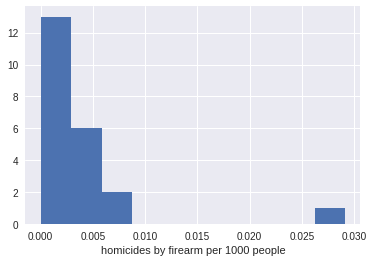

In [15]:
fig, ax = pl.subplots()
ax.hist(df_['homicides_by_firearm'] / df_['pop'] * 1000)
ax.set_xlabel('homicides by firearm per 1000 people');

**Description**<br>
This chart depecits the count of homicides by firearm per 1000 people. Most countries are hovering around 0, with one significant outlier, the United States.

### Homicides

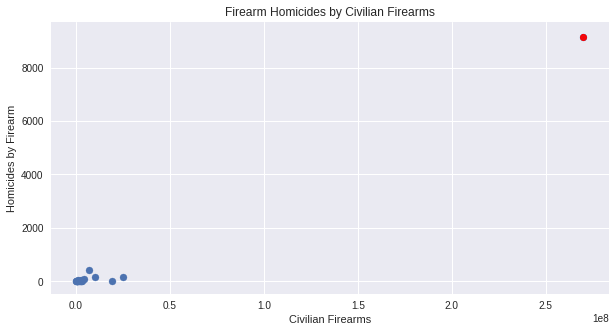

In [16]:
fig = pl.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(df_['civ_firearms'], 
                     df_['homicides_by_firearm'])

ax.errorbar(df_['civ_firearms'],
            df_['homicides_by_firearm'],
            yerr = np.sqrt(df_['homicides_by_firearm'] * 1.0), 
            fmt = '.')

pl.plot(df_['civ_firearms']['United States'],
        df_['homicides_by_firearm']['United States'],'ro')

ax.errorbar(df_['civ_firearms']['United States'], 
            df_['homicides_by_firearm']['United States'], 
            yerr = np.sqrt(df_['homicides_by_firearm']['United States'] * 1.0), 
            fmt = 'r.')

ax.set_ylabel("Homicides by Firearm")
ax.set_xlabel("Civilian Firearms")
ax.set_title('Firearm Homicides by Civilian Firearms')

**Description**<br>
This chart depicts the number of homicides by firearm in relation to the number of civilian firearms owned.

### Mass Shootings

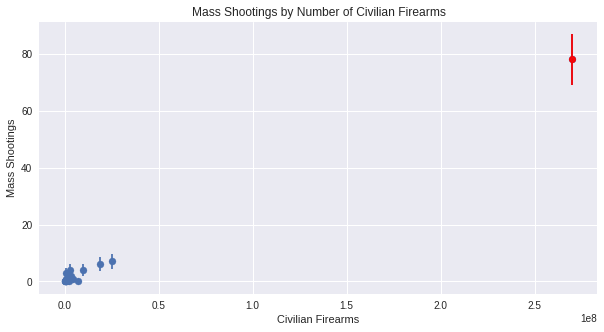

In [17]:
fig = pl.figure(figsize=(10,5)) 
ax = fig.add_subplot(111)
scatter = ax.scatter(df_['civ_firearms'], 
                     df_['mass_shootings'])

ax.errorbar(df_['civ_firearms'],
            df_['mass_shootings'],
            yerr = np.sqrt(df_['mass_shootings'] * 1.0), 
            fmt = '.')

pl.plot(df_['civ_firearms']['United States'],
        df_['mass_shootings']['United States'],'ro')

ax.errorbar(df_['civ_firearms']['United States'], 
            df_['mass_shootings']['United States'], 
            yerr = np.sqrt(df_['mass_shootings']['United States'] * 1.0), 
            fmt = 'r.')

ax.set_ylabel("Mass Shootings")
ax.set_xlabel("Civilian Firearms")
ax.set_title('Mass Shootings by Number of Civilian Firearms')

**Description**<br>
Here, we see the number of mass shootings per civilian firearms owned.

In [18]:
import statsmodels.regression.linear_model as lm
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

#df_['civ_firearms_scaled'] = df_['civ_firearms']/10**7
df_['mass_shootings_pp'] = df_['mass_shootings']/(df_['pop']/10**7)
df_['yerror'] = df_['mass_shootings_pp'].apply(np.sqrt)

lm = smf.ols(formula='mass_shootings_pp ~ firearms_per_pop',
             data = df_).fit()
wl = sm.WLS(df_.mass_shootings_pp, df_.firearms_per_pop, 
            weights=1./(0.5 + np.sqrt(df_['mass_shootings_pp'] * 1.0)))
wlm = wl.fit()

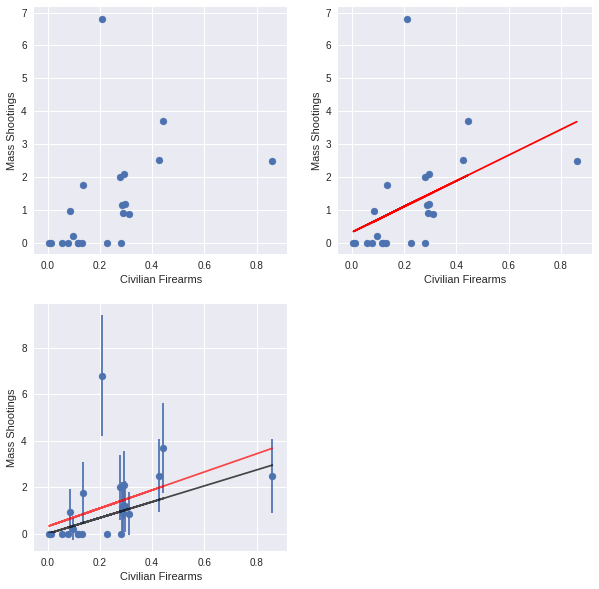

In [19]:
fig = pl.figure(figsize=(10,10)) 

ax = fig.add_subplot(221)
scatter = ax.scatter(df_['firearms_per_pop'],
                     df_['mass_shootings_pp'])
ax.set_ylabel("Mass Shootings")
ax.set_xlabel("Civilian Firearms")

ax = fig.add_subplot(222)
scatter = ax.scatter(df_['firearms_per_pop'],
                     df_['mass_shootings_pp'])
pl.plot(df_.firearms_per_pop,lm.predict(), 'r')
ax.set_ylabel("Mass Shootings")
ax.set_xlabel("Civilian Firearms")

ax = fig.add_subplot(223)
scatter = ax.scatter(df_['firearms_per_pop'],
                     df_['mass_shootings_pp'])
ax.errorbar(df_['firearms_per_pop'],
            df_['mass_shootings_pp'],
            yerr = np.sqrt(df_['mass_shootings_pp']), 
            fmt = '.')
pl.plot(df_.firearms_per_pop,lm.predict(), 'r', alpha=0.7)
pl.plot(df_.firearms_per_pop,wlm.predict(), 'k', alpha=0.7)
ax.set_ylabel("Mass Shootings")
ax.set_xlabel("Civilian Firearms")

**Description**<br>
The above graphs depict the relationship between Mass Shootings per Person and Civilian Firearm ownership. For the first time, we see that the US may not be the enourmous outlier it appears to be in the other charts, and may actually be below average in mass shootings per person (though 'mass shootings,' it should be noted, is different from our earlier investigation of homicides). That said, this is likely also due to the fact that so many people own guns in the US (and are not mass murderers), so this ratio does not seem too surprising. Finally, it should be noted that the US's performance sinks closer to the expected value when a weighted regression is applied.  

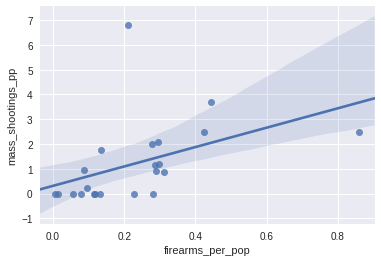

In [20]:
sns.regplot(x=df_['firearms_per_pop'], y=df_['mass_shootings_pp'], data=df_)

**Description**<br>
This gives a broader scope of the possible weightings of the regression line, within one standard deviation. 

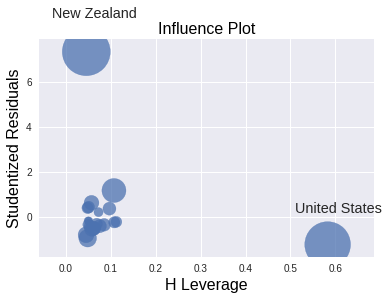

In [21]:
sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks");

**Description**<br>
This shows the relative influence on the regression weightings of each country. The United States weighs very heavy because of its high rate of gun ownership, and New Zealand has an extremely high relative rate of mass shootings per person (though this may be an annomoly as it is a very small country, famously having more sheep than people). 